# Power Quality Classification using Muti Layer Perceptron (Dataset 2)

This notebook focusses on developing a Multi Layer perceptron which classifies a particular power signal into its respective power quality condition. The dataset used here contains signals which belong to one of the 6 classes(power quality condition). The sampling rate of this data is 256. This means that each signal is characterized by 256 data points. Here the signals provided are in time domain.

In [1]:
#importing the required libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import datetime
from scipy.fft import fft,fftfreq
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam

In [2]:
#loading the dataset using pandas
x_train = pd.read_csv("../Dataset2/Train/Voltage_L1_train.csv")
y_train = pd.read_csv("../Dataset2/Train/output_train.csv")
x_test = pd.read_csv("../Dataset2/Test/Voltage_L1_test.csv")
y_test = pd.read_csv("../Dataset2/Test/output_test.csv")

In [3]:
print("x_train",x_train.shape)
print("y_train",y_train.shape)
print("x_test",x_test.shape)
print("y_test",y_test.shape)

x_train (5999, 256)
y_train (5999, 1)
x_test (3599, 256)
y_test (3599, 1)


## Data Preprocessing

This segment of notebook contains all the preprocessing steps which are performed on the data.

### Data cleaning

In [4]:
#dropna() function is used to remove all those rows which contains NA values
x_train.dropna(axis=0,inplace=True)
y_train.dropna(axis=0,inplace=True)
x_test.dropna(axis=0,inplace=True)
y_test.dropna(axis=0,inplace=True)

In [5]:
#shape of the data frame after dropping the rows containing NA values
print("x_train",x_train.shape)
print("y_train",y_train.shape)
print("x_test",x_test.shape)
print("y_test",y_test.shape)

x_train (5999, 256)
y_train (5999, 1)
x_test (3599, 256)
y_test (3599, 1)


In [6]:
#here we are constructing the array which will finally contain the column names
header =[]
for i in range(1,x_train.shape[1]+1):
    header.append("Col"+str(i))

In [7]:
#assigning the column name array to the respectinve dataframes
x_train.columns = header
x_test.columns = header

In [8]:
#assigning the column name array to the respectinve dataframes
header = ["output"]
y_train.columns = header
y_test.columns = header

In [9]:
x_train.head()

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,...,Col247,Col248,Col249,Col250,Col251,Col252,Col253,Col254,Col255,Col256
0,573.652486,1003.343736,1588.404525,2317.576741,2804.364311,3225.322510,3662.821690,4174.627969,4656.244143,4939.070130,...,-4650.282434,-4228.581226,-3865.609932,-3395.654756,-2933.680470,-2322.450904,-1841.562453,-1282.042025,-601.968217,-156.848367
1,4757.365183,5264.598912,5428.642486,5650.413073,5939.710012,5911.948067,6147.642171,6076.921501,5958.797444,6053.817701,...,-280.360872,323.325836,861.103019,1415.929276,2007.692919,2561.130303,2960.282598,3619.932691,4008.288701,4422.229911
2,4242.144824,4644.679402,5013.356532,5229.417051,5534.898007,5797.190678,5930.658682,5960.014599,6055.336310,6103.707793,...,-1256.270585,-616.527428,-67.068193,549.016676,1099.652199,1697.572166,2239.961604,2776.876479,3248.638662,3807.665149
3,2077.819247,2561.679246,3085.653813,3545.905160,4023.421592,4496.705157,4809.079868,5186.298840,5453.627533,5737.354699,...,-3557.345152,-3017.951179,-2596.647329,-1996.266675,-1467.203661,-885.101101,-329.685256,304.222722,935.528504,1460.127297
4,3599.645319,4099.944762,4499.282469,4897.875855,5120.077118,5402.227743,5694.801362,5928.683099,5981.616502,6052.006904,...,-2020.240712,-1388.704968,-849.731284,-232.632694,341.406093,854.579135,1528.023058,2002.557438,2576.468343,3036.303600


In [10]:
x_test.head()

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,...,Col247,Col248,Col249,Col250,Col251,Col252,Col253,Col254,Col255,Col256
0,4216.164293,4550.919227,4885.253969,5265.577080,5634.058181,5690.878844,5984.805444,6083.124480,6024.018340,6144.339029,...,-1279.720481,-672.204610,-35.247405,565.001817,1139.580709,1623.258946,2159.189259,2729.066018,3292.437301,3770.985050
1,795.638794,1340.736614,1928.805243,2465.916079,3009.942949,3475.153730,3938.568022,4372.781654,4765.603003,5090.817748,...,-4525.083123,-4077.498908,-3630.262875,-3176.648183,-2652.563485,-2135.982927,-1549.968773,-970.063115,-413.973048,202.507328
2,1220.943267,1770.550513,2318.816674,2850.186275,3357.786987,3848.017230,4274.339651,4669.175893,5027.840955,5329.856655,...,-4214.790563,-3762.024055,-3303.182589,-2802.950592,-2246.516780,-1712.153266,-1120.729328,-553.276475,43.863168,614.870963
3,1013.772210,1621.783618,2178.146635,2733.460484,3178.151416,3692.797702,4177.895304,4539.640464,4948.873847,5271.862849,...,-4371.401183,-3937.075334,-3502.317297,-2922.179500,-2467.320667,-1904.033355,-1362.385474,-704.032900,-188.518269,466.064827
4,4490.355896,4862.601717,5235.681699,5401.432840,5741.255908,5840.507807,6030.352157,6037.480783,6109.355580,6000.190091,...,-848.410798,-279.507713,269.777288,853.806015,1410.187144,1977.999116,2621.735468,3069.781180,3624.993700,4116.325633


In [11]:
y_train.head()

,output
0,1
1,1
2,1
3,1
4,1


In [12]:
y_test.head()

,output
0,1
1,1
2,1
3,1
4,1


In [13]:
#here we are splitting the training set in the ratio of 70%,30% (training set,validation set)
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.30, random_state=42)

In [14]:
# get_dummies function is used here to perform one hot encoding of the y_* numpy arrays
y_train_hot = pd.get_dummies(y_train['output'])
y_test_hot = pd.get_dummies(y_test['output'])
y_val_hot = pd.get_dummies(y_val['output'])

In [15]:
y_train_hot.head()

,1,2,3,4,5,6
927,1,0,0,0,0,0
3256,0,0,0,1,0,0
45,1,0,0,0,0,0
1260,0,1,0,0,0,0
1096,0,1,0,0,0,0


### Data transformation

The data transformation steps employed here are as follows:<br>

1) Fourier Transform<br>
2) Normalization

In [16]:
x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

In [17]:
#here we are overwritting the dataframe with the respective waves which we obtained after doing fourier 
#transformation
'''for i in range(0,x_train.shape[0]):
    x_train[i][:] = np.abs(fft(x_train[i][:]))
    
for i in range(0,x_test.shape[0]):
    x_test[i][:] = np.abs(fft(x_test[i][:]))

for i in range(0,x_val.shape[0]):
    x_val[i][:] = np.abs(fft(x_val[i][:]))'''

'for i in range(0,x_train.shape[0]):\n    x_train[i][:] = np.abs(fft(x_train[i][:]))\n    \nfor i in range(0,x_test.shape[0]):\n    x_test[i][:] = np.abs(fft(x_test[i][:]))\n\nfor i in range(0,x_val.shape[0]):\n    x_val[i][:] = np.abs(fft(x_val[i][:]))'

In [18]:
#here we are performing normalization
transform = StandardScaler()
x_train_tr = transform.fit_transform(x_train)
x_test_tr = transform.fit_transform(x_test)
x_val_tr = transform.fit_transform(x_val)

In [19]:
#final dimensions of the data
print("Training",x_train_tr.shape)
print(y_train_hot.shape)
print("Validation",x_val_tr.shape)
print(y_val_hot.shape)
print("Test",x_test_tr.shape)
print(y_test_hot.shape)
sampling_rate = x_train_tr.shape[1]

Training (4199, 256)
(4199, 6)
Validation (1800, 256)
(1800, 6)
Test (3599, 256)
(3599, 6)


## Model creation and training

In [20]:
def model_training(no_of_classes,sampling_rate):
    model = Sequential()

    model.add(Dense(64, input_shape=(sampling_rate,), activation = 'relu'))
    model.add(Dense(32, activation = 'relu'))
    #model.add(Dropout(0.6))
    model.add(Dense(16, activation = 'relu'))
    #model.add(Dropout(0.6))
    model.add(Dense(no_of_classes, activation = 'softmax'))

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    return(model)

In [31]:

log_dir = "logs2/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model = model_training(6,256)
history = model.fit(x_train_tr, y_train_hot, batch_size=64, epochs=30, validation_data=(x_val_tr, y_val_hot), callbacks=[tensorboard_callback])


Epoch 1/30
66/66 [==============================] - 1s 6ms/step - loss: 1.3685 - accuracy: 0.4600 - val_loss: 0.5088 - val_accuracy: 0.8644
Epoch 2/30
66/66 [==============================] - 0s 3ms/step - loss: 0.3786 - accuracy: 0.8712 - val_loss: 0.2836 - val_accuracy: 0.8556
Epoch 3/30
66/66 [==============================] - 0s 4ms/step - loss: 0.2438 - accuracy: 0.8771 - val_loss: 0.2410 - val_accuracy: 0.8644
Epoch 4/30
66/66 [==============================] - 0s 7ms/step - loss: 0.2132 - accuracy: 0.8931 - val_loss: 0.2572 - val_accuracy: 0.8506
Epoch 5/30
66/66 [==============================] - 0s 5ms/step - loss: 0.1982 - accuracy: 0.8970 - val_loss: 0.2157 - val_accuracy: 0.8800
Epoch 6/30
66/66 [==============================] - 0s 6ms/step - loss: 0.1972 - accuracy: 0.8998 - val_loss: 0.2229 - val_accuracy: 0.8850
Epoch 7/30
66/66 [==============================] - 0s 7ms/step - loss: 0.2018 - accuracy: 0.8946 - val_loss: 0.2185 - val_accuracy: 0.8783
Epoch 8/30
66/66 [==

In [32]:
%load_ext tensorboard
%tensorboard --logdir logs2/fit

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6010 (pid 87035), started 0:01:46 ago. (Use '!kill 87035' to kill it.)

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 102       
Total params: 19,158
Trainable params: 19,158
Non-trainable params: 0
_________________________________________________________________


## Model evaluation

In [34]:
np.mean(history.history['accuracy']) 

0.9112090150515239

In [24]:
pred_acc = model.evaluate(x_test_tr,y_test_hot)
print("Test accuracy is {}".format(pred_acc))

113/113 [==============================] - 0s 1ms/step - loss: 0.1357 - accuracy: 0.9378
Test accuracy is [0.13573575019836426, 0.9377604722976685]


In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [26]:
array = confusion_matrix(y_test_hot.to_numpy().argmax(axis=1), model.predict(x_test_tr).argmax(axis=1))

In [27]:
array

array([[546,   0,  53,   0,   0,   0],
       [  0, 600,   0,   0,   0,   0],
       [171,   0, 429,   0,   0,   0],
       [  0,   0,   0, 600,   0,   0],
       [  0,   0,   0,   0, 600,   0],
       [  0,   0,   0,   0,   0, 600]])

<AxesSubplot:>

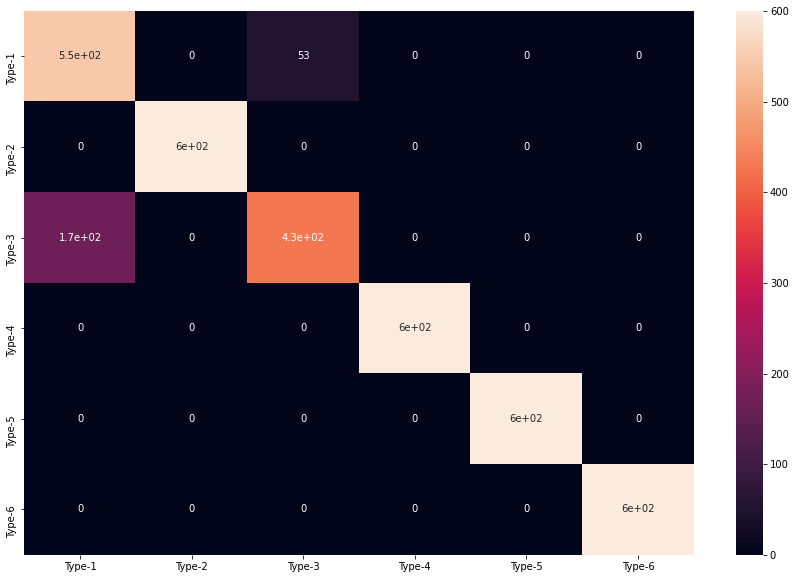

In [28]:
to_cm = pd.DataFrame(array, index = [i for i in ["Type-1","Type-2","Type-3","Type-4","Type-5","Type-6"]],
                  columns = [i for i in ["Type-1","Type-2","Type-3","Type-4","Type-5","Type-6"]])
plt.figure(figsize = (15,10))
sn.heatmap(to_cm, annot=True)

In [29]:
#model.save("model1.h5")